# 3D 2nd-order acoustic parabola

In this notebook, we will implement a basic 3D immersed boundary.

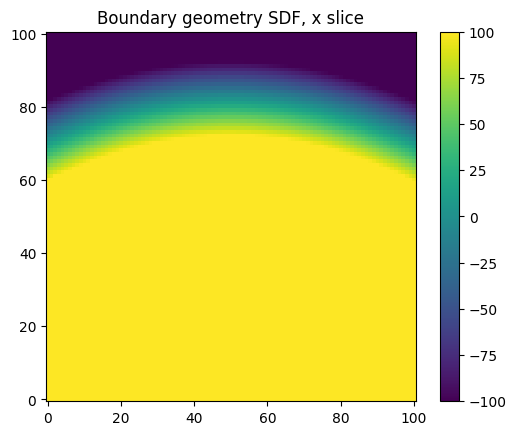

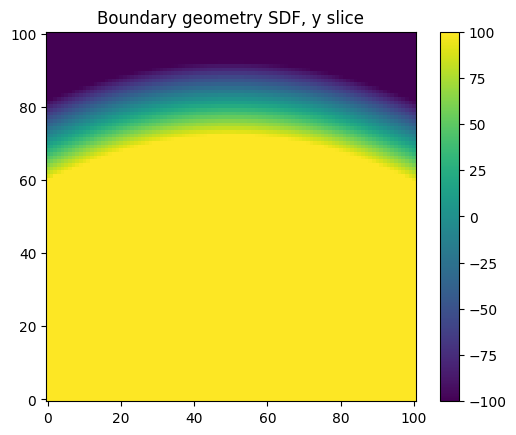

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = 'sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('parabola', 3)

midx = sdf.shape[0]//2
midy = sdf.shape[1]//2

plt.imshow(sdf.data[midx, :].T, origin='lower')
plt.title("Boundary geometry SDF, x slice")
plt.colorbar()
plt.show()

plt.imshow(sdf.data[:, midy].T, origin='lower')
plt.title("Boundary geometry SDF, y slice")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry

bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` generated in 0.33 s
  * lowering.IET: 0.12 s (37.0 %)
     * specializing.IET: 0.09 s (27.7 %)
  * lowering.Expressions: 0.12 s (37.0 %)
  * lowering.Clusters: 0.07 s (21.6 %)
Flops reduction after symbolic optimization: [45 --> 21]
Operator `normals` jit-compiled `/tmp/devito-jitcache-uid1000/858580807ec4bfc2bbedca4e5687701841d5b165.c` in 0.37 s with `GNUCompiler`
Operator `normals` ran in 0.01 s
Global performance: [OI=1.10, 4.50 GFlops/s]
Local performance:
  * section0<105,105,105> ran in 0.01 s [OI=1.10, 4.53 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 12}


In [3]:
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o, time_order=2)

In [4]:
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),  # Zero pressure on free surface
           dv.Eq(p.dx2+p.dy2+p.dz2, 0),  # Zero laplacian
           dv.Eq(p.dx4 + p.dy4 + p.dz4 + 2*p.dx2dy2 + 2*p.dx2dz2 + 2*p.dy2dz2, 0)]  # Zero biharmonic

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

In [6]:
derivs = (p.dx2, p.dy2, p.dz2)
subs = boundary.substitutions(derivs)

Generating stencils for: Derivative(p(t, x, y, z), (x, 2))
Generating stencils for: Derivative(p(t, x, y, z), (y, 2))
Generating stencils for: Derivative(p(t, x, y, z), (z, 2))


In [7]:
from examples.seismic import TimeAxis, RickerSource

c = 1

t0 = 0.  # Simulation starts a t=0
tn = 600.  # Simulation last 0.6 seconds (600 ms)
dt = 0.5*10/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 500.
src.coordinates.data[0, 2] = 500.

In [8]:
eq = dv.Eq(p.forward, 2*p-p.backward+dt**2*c**2*(subs[p.dx2]+subs[p.dy2]+subs[p.dz2]))

In [9]:
src_term = src.inject(field=p.forward, expr=c*src*dt**2)

In [10]:
op = dv.Operator([eq] + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` generated in 6.64 s
  * lowering.IET: 1.80 s (27.2 %)
  * lowering.Expressions: 1.58 s (23.9 %)
  * lowering.Clusters: 1.48 s (22.4 %)
Flops reduction after symbolic optimization: [527 --> 489]
Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid1000/dd3e539f35ee1e8c8931f9edc567bb730a82f1d0.c` in 25.37 s with `GNUCompiler`
Operator `Kernel` ran in 13.41 s
Global performance: [OI=0.50, 4.52 GFlops/s, 0.01 GPts/s]
Local performance:
  * section0<120,12,12,8,8,101> ran in 13.40 s [OI=0.50, 4.52 GFlops/s, 0.01 GPts/s]
  * section1<<120,1>,<120,1>,<120,1>,<120,1>,<120,1>,<120,1>,<120,1>,<120,1>,<120,1>> ran in 0.01 s [OI=155.25, 0.16 GFlops/s, 0.01 GPts/s]
Performance[mode=advanced] arguments: {'nthreads': 12, 'nthreads_nonaffine': 12, 'x0_blk0_size': 8, 'y0_blk0_size': 8}


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=13.397361, gflopss=4.51268445181107, gpointss=0.009228393561985827, oi=0.4984006100452755, ops=489, itershapes=((120, 12, 12, 8, 8, 101),))),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0014570000000000004, gflopss=0.15343857240905967, gpointss=8.236101578586133e-05, oi=155.25, ops=1863, itershapes=((120, 1), (120, 1), (120, 1), (120, 1), (120, 1), (120, 1), (120, 1), (120, 1), (120, 1))))])

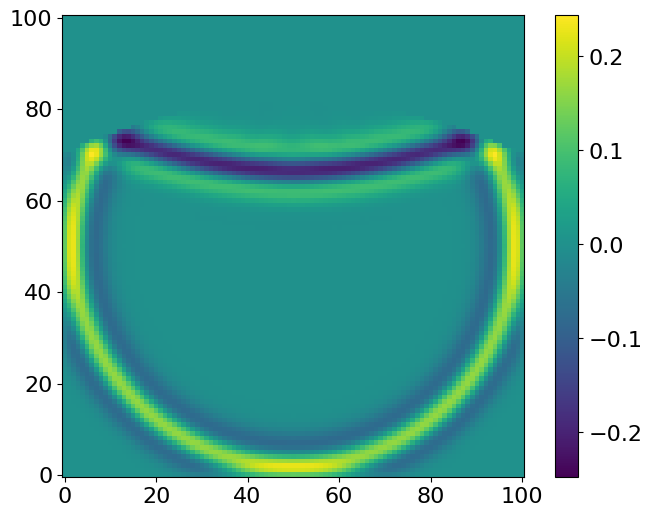

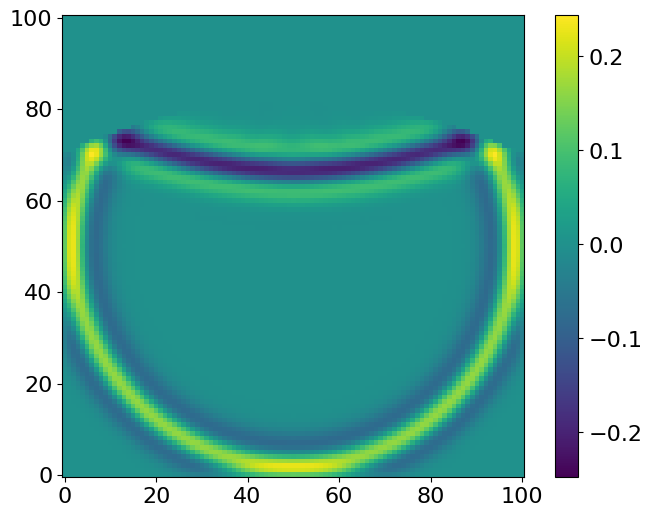

In [13]:
plt.imshow(p.data[1, midx].T, origin='lower')
plt.colorbar()
plt.show()

plt.imshow(p.data[1, :, midy].T, origin='lower')
plt.colorbar()
plt.show()